In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import gc

In [2]:
df = pd.read_pickle("../data/RDKit/rdkit_only_valid_smiles_qm9.pkl")
# Check the info of the dataframe, especially important is the dtypes of the columns
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129012 entries, 0 to 129011
Columns: 219 entries, MaxAbsEStateIndex to gaps
dtypes: float64(108), int64(110), object(1)
memory usage: 215.6+ MB
None


In [3]:
df.select_dtypes(include=[object])

,SMILES
0,[H]C([H])([H])[H]
1,[H]N([H])[H]
2,[H]O[H]
3,[H]C#C[H]
4,[H]C#N
...,...
129007,[H]C1([H])[C@@]23[N@H+]4[C@@]5([H])[C@]1([H])[...
129008,[H]C1([H])[C@@]2([H])[C@@]3([H])[C@@]14O[C@]1(...
129009,[H]C1([H])[N@@H+]2[C@@]3([H])[C@]2([H])[C@]2([...
129010,[H]C1([H])[N@H+]2[C@@]3([H])[C@@]14C([H])([H])...


Machine learning models can't generally handle strings (the SMILES of the molecules in our case).

Based on the type of data that is encoded in the string, the following optoins are available

- Categorical (small set of discrete values) $\rightarrow$ Use label encoding or one-hot encoding
- Text (sentences, descriptions, reviews, etc.) $\rightarrow$ Use text vectorization (TF-IDF, embeddings, etc.)
- IDs or identifiers (like user IDs, product codes) $\rightarrow$ Usually drop them, unless they carry domain meaning
- Mixed or corrupted data $\rightarrow$ Clean or cast to the proper type (e.g., numeric or datetime)

In our case, the SMILES act as IDs for the molecule, so we can drop them. This will not be a problem as the data of the SMILES is all encoded into the 217 features.

In [4]:
# Split features and target
X = df.drop(columns=['gaps', 'SMILES']) # Drop the target variable and the SMILES objects
y = df['gaps']

Create Stratification Bins

I have found two methods from pandas:
- Option A: Quantile bins, the number of elements in each bin will be roughly the same, but this will come at the cost of differently sized interval widths.
- Option B: pd.cut function, in which the bin edges were equal sized with uneven number of elements in each bin or group.

I think qcut is better

In [5]:
num_bins = 10  # 10 bins for deciles
gap_bins_outer = pd.qcut(y, q=num_bins, labels=False)

In [6]:
X.iloc[4]

MaxAbsEStateIndex    6.500000
MaxEStateIndex       6.500000
MinAbsEStateIndex    3.500000
MinEStateIndex       3.500000
qed                  0.369797
                       ...   
fr_thiazole          0.000000
fr_thiocyan          0.000000
fr_thiophene         0.000000
fr_unbrch_alkane     0.000000
fr_urea              0.000000
Name: 4, Length: 217, dtype: float64

In [7]:
storage_path = "../data/LightGBM/unprocessed/"

import os
if not os.path.exists(storage_path): os.makedirs(storage_path)

In [8]:
# Different seed for outer and inner CV
outer_seed = 42
inner_seed = 123

# Outer CV (train/test), 80/20 split of total dataset
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=outer_seed)

for outer_fold_idx, (train_idx, test_idx) in enumerate(outer_cv.split(X, gap_bins_outer)):

    #Split into train/test
    X_train_outer, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train_outer, y_test = y.iloc[train_idx], y.iloc[test_idx]

    outer_fold = {
        "outer_fold_idx": outer_fold_idx,
        "X_test": X_test,
        "y_test": y_test,
        "inner_folds": []
    }
    
    # Create second binning that only works on the outer train data
    gap_bins_inner = pd.qcut(y_train_outer, q=num_bins, labels=False)

    # Inner CV (train/val), 72/8 split of total dataset
    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=inner_seed)


    for inner_fold_idx, (inner_train_idx, val_idx) in enumerate(inner_cv.split(X_train_outer, gap_bins_inner)):

        # Split into train/validation
        X_train_inner, X_val = X_train_outer.iloc[inner_train_idx], X_train_outer.iloc[val_idx]
        y_train_inner, y_val = y_train_outer.iloc[inner_train_idx], y_train_outer.iloc[val_idx]

        inner_fold = {
            "inner_fold_idx": inner_fold_idx,
            "X_train": X_train_inner,
            "y_train": y_train_inner,
            "X_val": X_val,
            "y_val": y_val
        }

        # Append inner fold to outer fold
        outer_fold["inner_folds"].append(inner_fold)
    
    # Save outer fold to disk
    filename = f"outer_fold_{outer_fold_idx}.pkl"
    with open((storage_path+filename), "wb") as f:
        pickle.dump(outer_fold, f)
    
    print(f"Saved {filename}")

    # Free up memory before moving to next outer outer fold
    del X_train_outer, X_test, y_train_outer, y_test, outer_fold
    gc.collect()


Saved outer_fold_0.pkl
Saved outer_fold_1.pkl
Saved outer_fold_2.pkl
Saved outer_fold_3.pkl
Saved outer_fold_4.pkl


In [10]:
with open("../data/LightGBM/unprocessed/outer_fold_2.pkl", "rb") as f:
    outer_fold_2 = pickle.load(f)

print(outer_fold_2.keys())

dict_keys(['outer_fold_idx', 'X_test', 'y_test', 'inner_folds'])


In [11]:
inner_fold_1 = outer_fold_2["inner_folds"][1]
print(inner_fold_1.keys())

dict_keys(['inner_fold_idx', 'X_train', 'y_train', 'X_val', 'y_val'])


In [12]:
y_train = inner_fold_1['y_train']
y_val = inner_fold_1['y_val']
y_test = outer_fold_2['y_test']

In [ ]:
# Stratified Train/Test Split
# X_tv, X_test, y_tv, y_test = train_test_split(
#     X, y,
#     test_size=0.15,
#     random_state=42,
#     stratify=gap_bins
# )

In [ ]:
# gap_bins_2 = pd.qcut(y_tv, q=num_bins, labels=False)

In [ ]:
# Stratified Train/Validation Split
# X_train, X_validation, y_train, y_validation = train_test_split(
#     X_tv, y_tv,
#     test_size=0.06,
#     random_state=42,
#     stratify=gap_bins_2
# )

In [ ]:
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# folds = []
# for fold, (train_idx, val_idx) in enumerate(skf.split(X_tv, gap_bins_2)):
#     X_train, X_val = X_tv.iloc[train_idx], X_tv.iloc[val_idx]
#     y_train, y_val = y_tv.iloc[train_idx], y_tv.iloc[val_idx]

#     folds.append({
#         "fold": fold,
#         "X_train": X_train,
#         "y_train": y_train,
#         "X_val": X_val,
#         "y_val": y_val
#     })

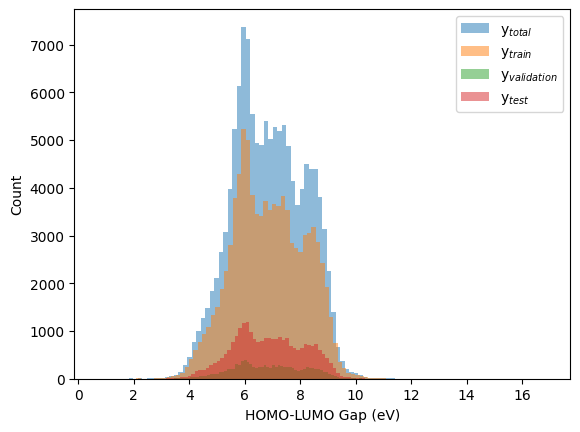

In [13]:
# Verify the Stratification
plt.hist(y, bins=100, alpha=0.5, label=r'y$_{total}$')
plt.hist(y_train, bins=100, alpha=0.5, label=r'y$_{train}$')
plt.hist(y_val, bins=100, alpha=0.5, label=r'y$_{validation}$')
plt.hist(y_test, bins=100, alpha=0.5, label=r'y$_{test}$')

plt.xlabel('HOMO-LUMO Gap (eV)')
plt.ylabel('Count')
plt.legend()
plt.show()

In [ ]:
print(y_train.shape[0] + y_test.shape[0] + y_val.shape[0])

pd.concat([y_train, y_test, y_val]).shape

129012


(129012,)

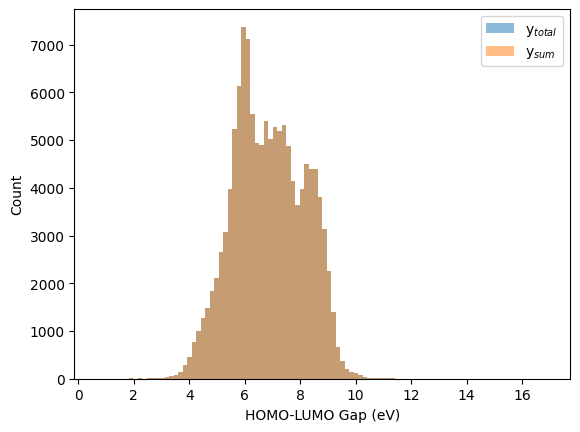

: 

In [ ]:
plt.hist(y, bins=100, alpha=0.5, label=r'y$_{total}$')
plt.hist(pd.concat([y_train, y_test, y_val]), bins=100, alpha=0.5, label=r'y$_{sum}$')

plt.xlabel('HOMO-LUMO Gap (eV)')
plt.ylabel('Count')
plt.legend()
plt.show()